In [ ]:
# read in data from plotly to plot simple tracks from 2017-2024 (Updated Jan 14th)
# https://viz.pmel.noaa.gov/saildrone/mission?mission_id=2017_1_tpos&drone=1005.0&drone=1006.0&trace_decimation=3&trace_variable=TEMP_O2_MEAN&plots_decimation=24&timeseries=TEMP_O2_MEAN&start_date=2017-09-02T00:00:00Z&end_date=2018-05-16T12:00:00Z&columns=1&mode=lines&plots_per=all


In [2]:
import xarray as xr
path = '/Users/katiekohlman/Desktop/Saildrone/mission-tracks/data'


In [3]:
test = xr.open_dataset('/Users/katiekohlman/Desktop/Saildrone/mission-tracks/data/sd1033_tpos_2023_bedc_c077_d7c6.nc')

In [4]:
test

<xarray.Dataset> Size: 6MB
Dimensions:          (trajectory: 1, obs: 193310)
Coordinates:
  * trajectory       (trajectory) object 8B '1033.0'
    time             (obs) datetime64[ns] 2MB ...
    latitude         (obs) float64 2MB ...
    longitude        (obs) float64 2MB ...
Dimensions without coordinates: obs
Data variables:
    rowSize          (trajectory) int32 4B ...
    TEMP_SBE37_MEAN  (obs) float64 2MB ...
Attributes: (12/56)
    acknowledgement:                     If you use these data in publication...
    area:                                Pacific Ocean
    cdm_data_type:                       Trajectory
    cdm_trajectory_variables:            trajectory
    citation:                            Please cite Sabine et. al. (2020) wh...
    contributor_email:                   Stacy.maenner@noaa.gov; Nathan.ander...
    ...                                  ...
    time_coverage_resolution:            PT1M
    time_coverage_start:                 2023-06-22T00:00:00Z
    time_in:                             minutes
    title:                               Saildrone PMEL TPOS 2023 Mission, dr...
    Westernmost_Easting:                 -170.6745344
    wmo_id:                              4803911

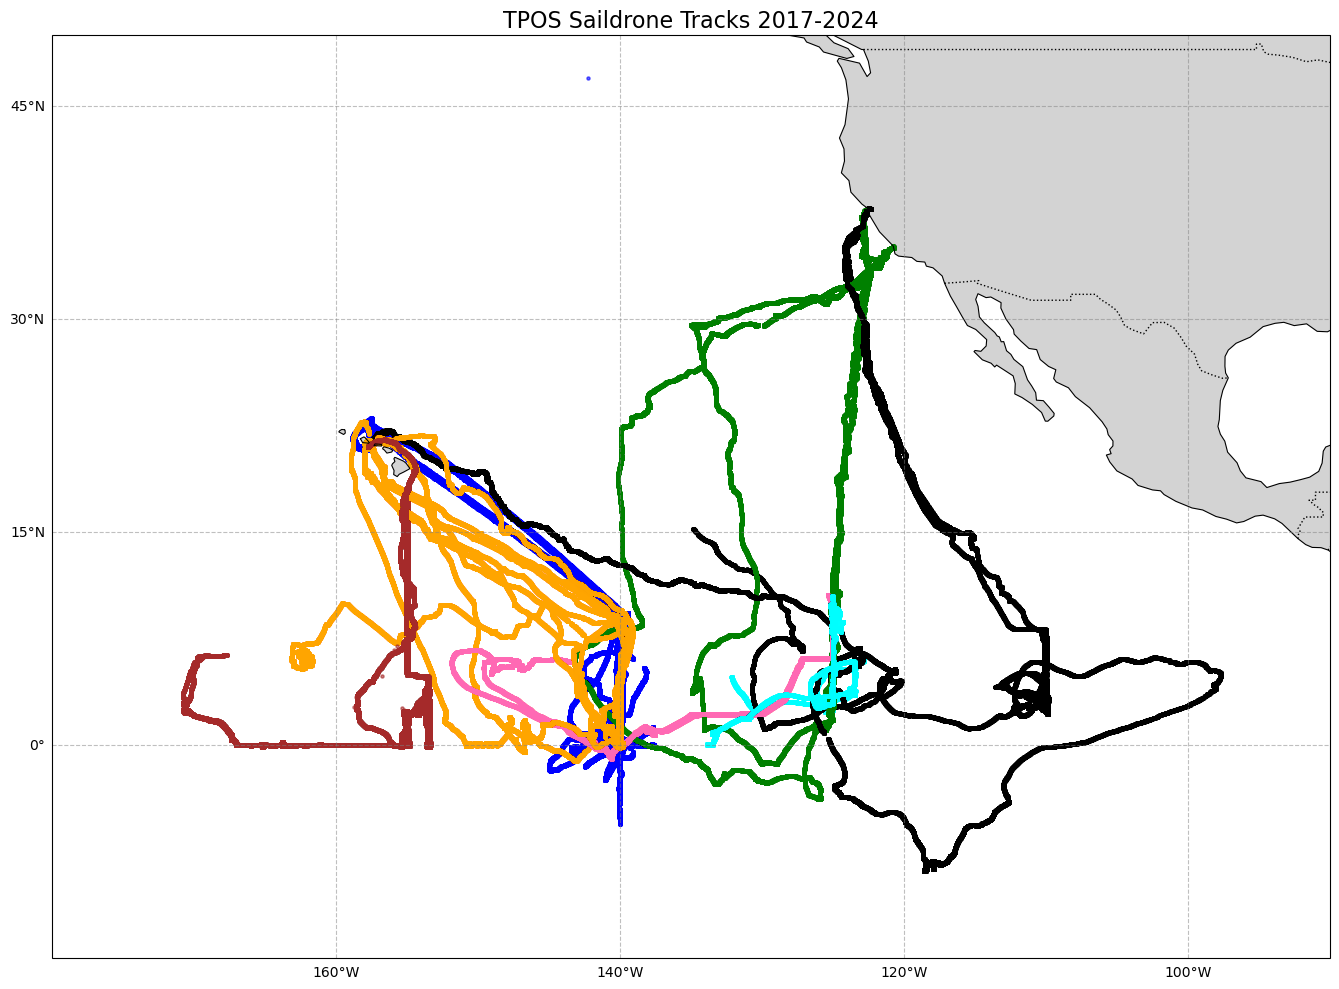

In [33]:
import os
import glob
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from itertools import cycle
from collections import defaultdict
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Path to the data directory
path = '/Users/katiekohlman/Desktop/Saildrone/mission-tracks/data'

# Define years to include in the plot
years_to_include = [2017, 2018, 2019, 2021, 2022, 2023, 2024]

# Define a dictionary to map each year to a base color
year_colors = {
    2017: 'green',
    2018: 'orange',
    2019: 'blue',
    2021: 'black',
    2022: 'cyan',
    2023: 'brown',
    2024: 'hotpink'
}
# Use a dictionary to group files and assign slightly different colors for each drone within the same year
drone_data = defaultdict(list)

# Loop through all NetCDF files in the directory
for file in glob.glob(os.path.join(path, "*.nc")):
    # Extract the filename
    base_name = os.path.basename(file)

    # Parse drone name and year from the filename
    try:
        # Adjusted parsing for filenames with "_tpos_"
        if '_tpos_' in base_name:
            drone_name = base_name.split('_tpos_')[0]  # e.g., 'sd1033'
            year = int(base_name.split('_tpos_')[1].split('_')[0])  # e.g., '2022'
        else:
            # Fallback for filenames without "_tpos_"
            drone_name = base_name.split('_')[0]  # e.g., 'sd1069'
            year = int(base_name.split('_')[1])  # e.g., '2019'

        if year in years_to_include:
            drone_data[(year, drone_name)].append(file)

    except (IndexError, ValueError):
        print(f"Unexpected file format: {file}")

# Initialize a plot with Cartopy
plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map extent focusing on the tropical Pacific region
ax.set_extent([-180, -90, -15, 50], crs=ccrs.PlateCarree())  # Longitude: -180 to -120, Latitude: -15 to 50

# Add coastlines and other features
ax.coastlines(resolution='110m', linewidth=0.8)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add gridlines and lat/lon ticks
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False  # Disable top labels
gl.right_labels = False  # Disable right labels
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
gl.xlocator = plt.MaxNLocator(5)  # Longitude ticks
gl.ylocator = plt.MaxNLocator(5)  # Latitude ticks

# Plot data with unique colors for each year and drone
scatter_handles = []  # To collect scatter handles for custom legend
scatter_labels = []  # To collect scatter labels for custom legend

for (year, drone_name), files in drone_data.items():
    base_color = year_colors[year]
    shades = np.linspace(0.6, 1.0, len(files))  # Lighter shades for more drones
    shade_cycle = cycle(shades)  # Cycle through shades for multiple files

    for file in files:
        try:
            with netCDF4.Dataset(file, 'r') as nc:
                # Read latitude and longitude
                lat = nc.variables['latitude'][:]
                lon = nc.variables['longitude'][:]
                
                # Check for fill values or invalid data
                fill_value = getattr(nc.variables['latitude'], '_FillValue', None)
                if fill_value is None:
                    fill_value = getattr(nc.variables['latitude'], 'missing_value', None)

                # Replace fill values with NaN
                if fill_value is not None:
                    lat = np.where(lat == fill_value, np.nan, lat)
                    lon = np.where(lon == fill_value, np.nan, lon)

                # Filter out invalid data
                valid_indices = np.isfinite(lat) & np.isfinite(lon)
                lat = lat[valid_indices]
                lon = lon[valid_indices]

                # Get a slightly lighter or darker shade of the base color
                alpha = next(shade_cycle)
                rgba_color = to_rgba(base_color, alpha=alpha)

                # Scatter plot the data
                scatter = ax.scatter(
                    lon, lat, color=rgba_color, label=f'{drone_name} ({year})',
                    s=5, transform=ccrs.PlateCarree()
                )
                scatter_handles.append(scatter)
                scatter_labels.append(f'{drone_name} ({year})')

        except Exception as e:
            print(f"Error processing file {file}: {e}")

# Format the plot
ax.set_title("TPOS Saildrone Tracks 2017-2024", fontsize=16)

# Create a sorted legend with years in descending order
sorted_legend = sorted(zip(scatter_labels, scatter_handles), key=lambda x: int(x[0].split('(')[-1].split(')')[0]), reverse=True)
sorted_labels, sorted_handles = zip(*sorted_legend)

#plt.legend(sorted_handles, sorted_labels, loc='upper left', fontsize='large', title='TPOS Saildones')

# Show the plot
plt.tight_layout()
plt.show()


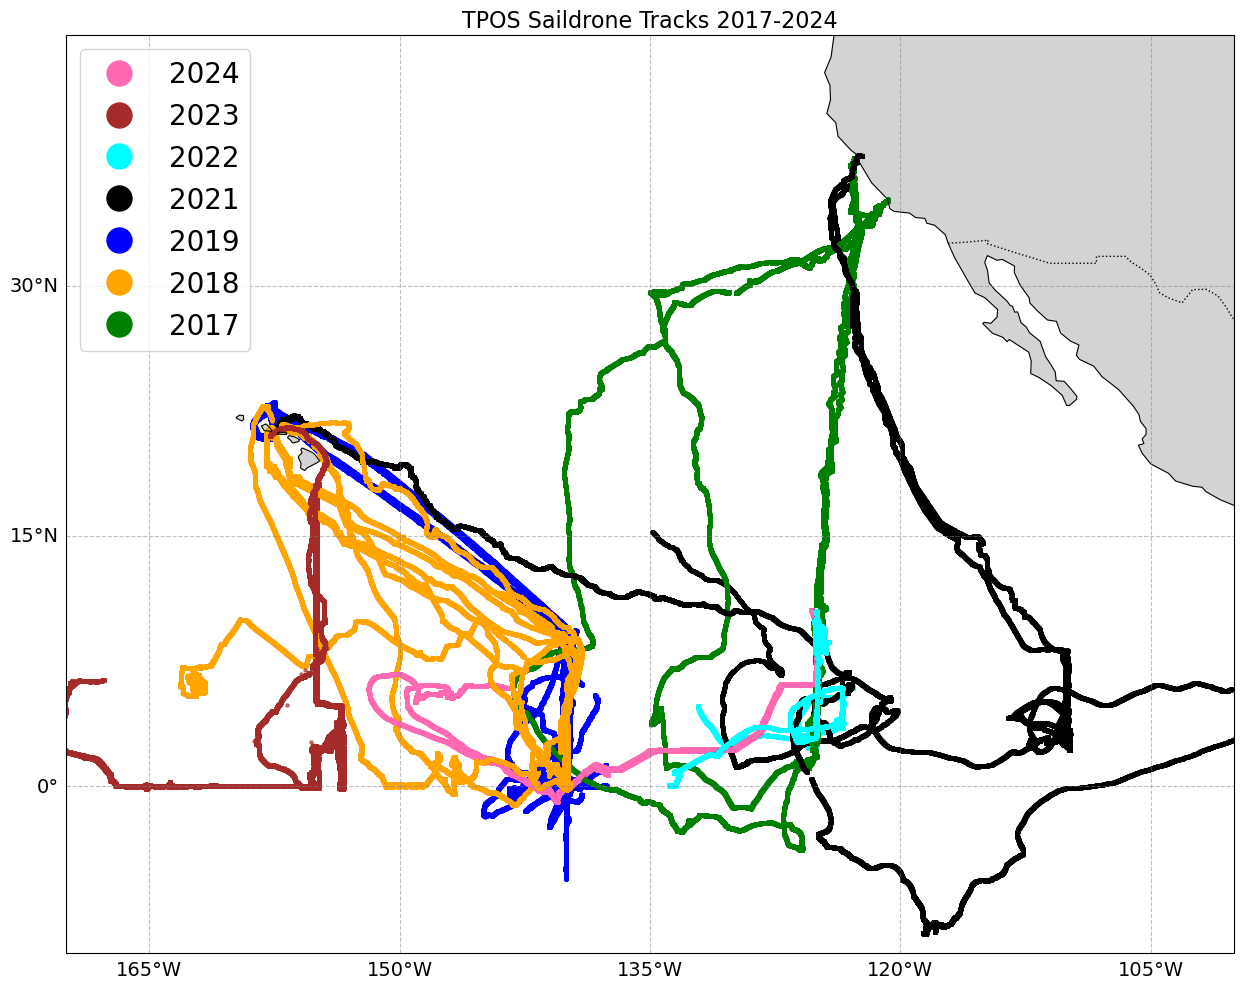

In [5]:
import os
import glob
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from itertools import cycle
from collections import defaultdict
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Path to the data directory
path = '/Users/katiekohlman/Desktop/Saildrone/mission-tracks/data'

# Define years to include in the plot
years_to_include = [2017, 2018, 2019, 2021, 2022, 2023, 2024]

# Define a dictionary to map each year to a base color
year_colors = {
    2017: 'green',
    2018: 'orange',
    2019: 'blue',
    2021: 'black',
    2022: 'cyan',
    2023: 'brown',
    2024: 'hotpink'
}

# Use a dictionary to group files and assign slightly different colors for each drone within the same year
drone_data = defaultdict(list)

# Loop through all NetCDF files in the directory
for file in glob.glob(os.path.join(path, "*.nc")):
    # Extract the filename
    base_name = os.path.basename(file)

    # Parse drone name and year from the filename
    try:
        # Adjusted parsing for filenames with "_tpos_"
        if '_tpos_' in base_name:
            drone_name = base_name.split('_tpos_')[0]  # e.g., 'sd1033'
            year = int(base_name.split('_tpos_')[1].split('_')[0])  # e.g., '2022'
        else:
            # Fallback for filenames without "_tpos_"
            drone_name = base_name.split('_')[0]  # e.g., 'sd1069'
            year = int(base_name.split('_')[1])  # e.g., '2019'

        if year in years_to_include:
            drone_data[(year, drone_name)].append(file)

    except (IndexError, ValueError):
        print(f"Unexpected file format: {file}")

# Initialize a plot with Cartopy
plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map extent focusing on the tropical Pacific region
ax.set_extent([-170, -100, -10, 45], crs=ccrs.PlateCarree())  # Longitude: -180 to -120, Latitude: -15 to 50

# Add coastlines and other features
ax.coastlines(resolution='110m', linewidth=0.8)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add gridlines and lat/lon ticks
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False  # Disable top labels
gl.right_labels = False  # Disable right labels
gl.xlabel_style = {'size': 14}  # Increase x-axis tick label size
gl.ylabel_style = {'size': 14}  # Increase y-axis tick label size
gl.xlocator = plt.MaxNLocator(5)  # Longitude ticks
gl.ylocator = plt.MaxNLocator(5)  # Latitude ticks

# Plot data with unique colors for each year and drone
scatter_handles = []  # To collect scatter handles for custom legend
scatter_labels = []  # To collect scatter labels for custom legend

for (year, drone_name), files in drone_data.items():
    base_color = year_colors[year]
    shades = np.linspace(0.6, 1.0, len(files))  # Lighter shades for more drones
    shade_cycle = cycle(shades)  # Cycle through shades for multiple files

    for file in files:
        try:
            with netCDF4.Dataset(file, 'r') as nc:
                # Read latitude and longitude
                lat = nc.variables['latitude'][:]
                lon = nc.variables['longitude'][:]
                
                # Check for fill values or invalid data
                fill_value = getattr(nc.variables['latitude'], '_FillValue', None)
                if fill_value is None:
                    fill_value = getattr(nc.variables['latitude'], 'missing_value', None)

                # Replace fill values with NaN
                if fill_value is not None:
                    lat = np.where(lat == fill_value, np.nan, lat)
                    lon = np.where(lon == fill_value, np.nan, lon)

                # Filter out invalid data
                valid_indices = np.isfinite(lat) & np.isfinite(lon)
                lat = lat[valid_indices]
                lon = lon[valid_indices]

                # Get a slightly lighter or darker shade of the base color
                alpha = next(shade_cycle)
                rgba_color = to_rgba(base_color, alpha=alpha)

                # Scatter plot the data
                scatter = ax.scatter(
                    lon, lat, color=rgba_color, label=f'{drone_name} ({year})',
                    s=5, transform=ccrs.PlateCarree()
                )
                scatter_handles.append(scatter)
                scatter_labels.append(f'{drone_name} ({year})')

        except Exception as e:
            print(f"Error processing file {file}: {e}")

# Format the plot
ax.set_title("TPOS Saildrone Tracks 2017-2024", fontsize=16)

# Create a sorted legend with years in descending order (only year colors, not drones)
unique_years = sorted(year_colors.keys(), reverse=True)
legend_labels = [f'{year}' for year in unique_years]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=year_colors[year], markersize=20) for year in unique_years]

# Adding the legend for mission years (colors)
# Adding the legend for mission years (colors)
ax.legend(handles=legend_handles, labels=legend_labels, loc='upper left', fontsize=20)


# Show the plot
plt.tight_layout()
plt.show()


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_53055/850515765.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['time'])


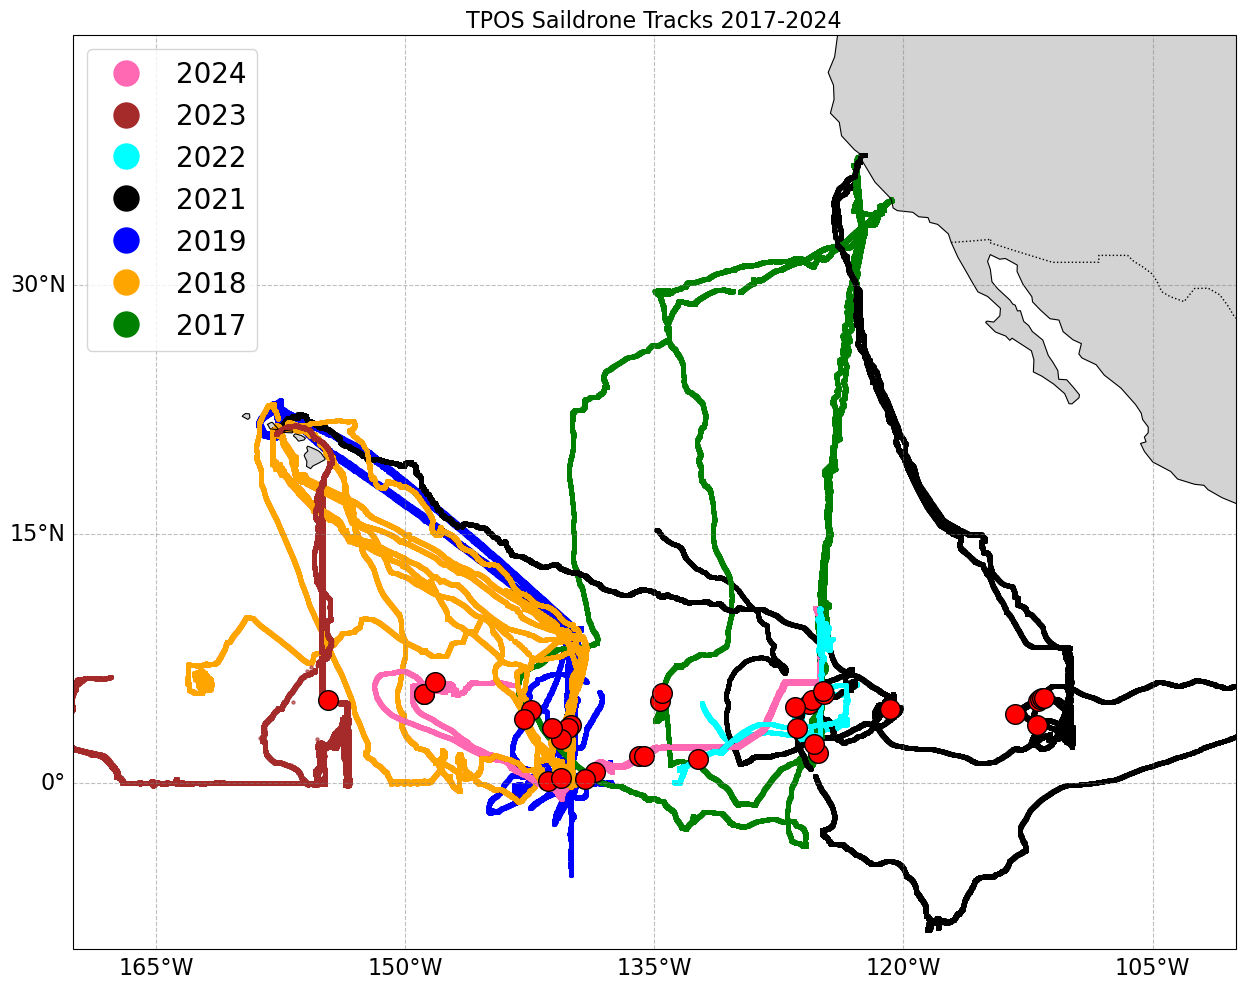

In [10]:
import os
import glob
import netCDF4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from itertools import cycle
from collections import defaultdict
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Path to the saildrone track data directory
path = '/Users/katiekohlman/Desktop/Saildrone/mission-tracks/data'

# Path to the fronts CSV file
file_path = '/Volumes/external/TIW/csv/Saildrone-fronts-QC-with-phase.csv'

# Load fronts data
df = pd.read_csv(file_path)

# Convert 'timestamp' to datetime format and filter valid fronts
df['time'] = pd.to_datetime(df['time'])
valid_fronts = df[df['manual_QC'] == 0]  # Only fronts with manual QC == 0
#valid_fronts= valid_fronts[valid_fronts['idx'] == 138328]
valid_fronts= valid_fronts[valid_fronts['lat'] <7]

# Define years to include in the plot
years_to_include = [2017, 2018, 2019, 2021, 2022, 2023, 2024]

# Define a dictionary to map each year to a base color
year_colors = {
    2017: 'green',
    2018: 'orange',
    2019: 'blue',
    2021: 'black',
    2022: 'cyan',
    2023: 'brown',
    2024: 'hotpink'
}

# Use a dictionary to group files and assign slightly different colors for each drone within the same year
drone_data = defaultdict(list)

# Loop through all NetCDF files in the directory
for file in glob.glob(os.path.join(path, "*.nc")):
    # Extract the filename
    base_name = os.path.basename(file)

    # Parse drone name and year from the filename
    try:
        if '_tpos_' in base_name:
            drone_name = base_name.split('_tpos_')[0]  # e.g., 'sd1033'
            year = int(base_name.split('_tpos_')[1].split('_')[0])  # e.g., '2022'
        else:
            drone_name = base_name.split('_')[0]  # e.g., 'sd1069'
            year = int(base_name.split('_')[1])  # e.g., '2019'

        if year in years_to_include:
            drone_data[(year, drone_name)].append(file)

    except (IndexError, ValueError):
        print(f"Unexpected file format: {file}")

# Initialize a plot with Cartopy
plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map extent focusing on the tropical Pacific region
ax.set_extent([-170, -100, -10, 45], crs=ccrs.PlateCarree()) 

# Add coastlines and other features
ax.coastlines(resolution='110m', linewidth=0.8)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add gridlines and lat/lon ticks
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}
gl.xlocator = plt.MaxNLocator(5)
gl.ylocator = plt.MaxNLocator(5)

# Plot data with unique colors for each year and drone
scatter_handles = []
scatter_labels = []

for (year, drone_name), files in drone_data.items():
    base_color = year_colors[year]
    shades = np.linspace(0.6, 1.0, len(files))
    shade_cycle = cycle(shades)

    for file in files:
        try:
            with netCDF4.Dataset(file, 'r') as nc:
                # Read latitude and longitude
                lat = nc.variables['latitude'][:]
                lon = nc.variables['longitude'][:]

                # Check for fill values or invalid data
                fill_value = getattr(nc.variables['latitude'], '_FillValue', None)
                if fill_value is None:
                    fill_value = getattr(nc.variables['latitude'], 'missing_value', None)

                # Replace fill values with NaN
                if fill_value is not None:
                    lat = np.where(lat == fill_value, np.nan, lat)
                    lon = np.where(lon == fill_value, np.nan, lon)

                # Filter out invalid data
                valid_indices = np.isfinite(lat) & np.isfinite(lon)
                lat = lat[valid_indices]
                lon = lon[valid_indices]

                # Get a slightly lighter or darker shade of the base color
                alpha = next(shade_cycle)
                rgba_color = to_rgba(base_color, alpha=alpha)

                # Scatter plot the data
                scatter = ax.scatter(
                    lon, lat, color=rgba_color, label=f'{drone_name} ({year})',
                    s=5, transform=ccrs.PlateCarree()
                )
                scatter_handles.append(scatter)
                scatter_labels.append(f'{drone_name} ({year})')

        except Exception as e:
            print(f"Error processing file {file}: {e}")

# Overlay 'X' markers for valid fronts on corresponding saildrone tracks
for _, row in valid_fronts.iterrows():
    front_year = row['Mission']
    front_drone = row['SD']
    front_lat = row['lat']
    front_lon = row['lon']

    if front_year in years_to_include:
        ax.scatter(
            front_lon, front_lat, color='red', marker='o', edgecolors='k', linewidth=1, s=200,
            label=f'Front {front_drone} ({front_year})', transform=ccrs.PlateCarree()
        )

# Format the plot
ax.set_title("TPOS Saildrone Tracks 2017-2024", fontsize=16)

# Create a sorted legend with years in descending order (only year colors, not drones)
unique_years = sorted(year_colors.keys(), reverse=True)
legend_labels = [f'{year}' for year in unique_years]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=year_colors[year], markersize=20) for year in unique_years]

# Adding the legend for mission years (colors)
ax.legend(handles=legend_handles, labels=legend_labels, loc='upper left', fontsize=20)

# Show the plot
plt.tight_layout()
plt.show()


/var/folders/kp/k4k3ytr53rb5v8r9c02hm7ch0000gn/T/ipykernel_31332/868943149.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['time'])
/Users/katiekohlman/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1762: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)
/Users/katiekohlman/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1762: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)
/Users/katiekohlman/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1762: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


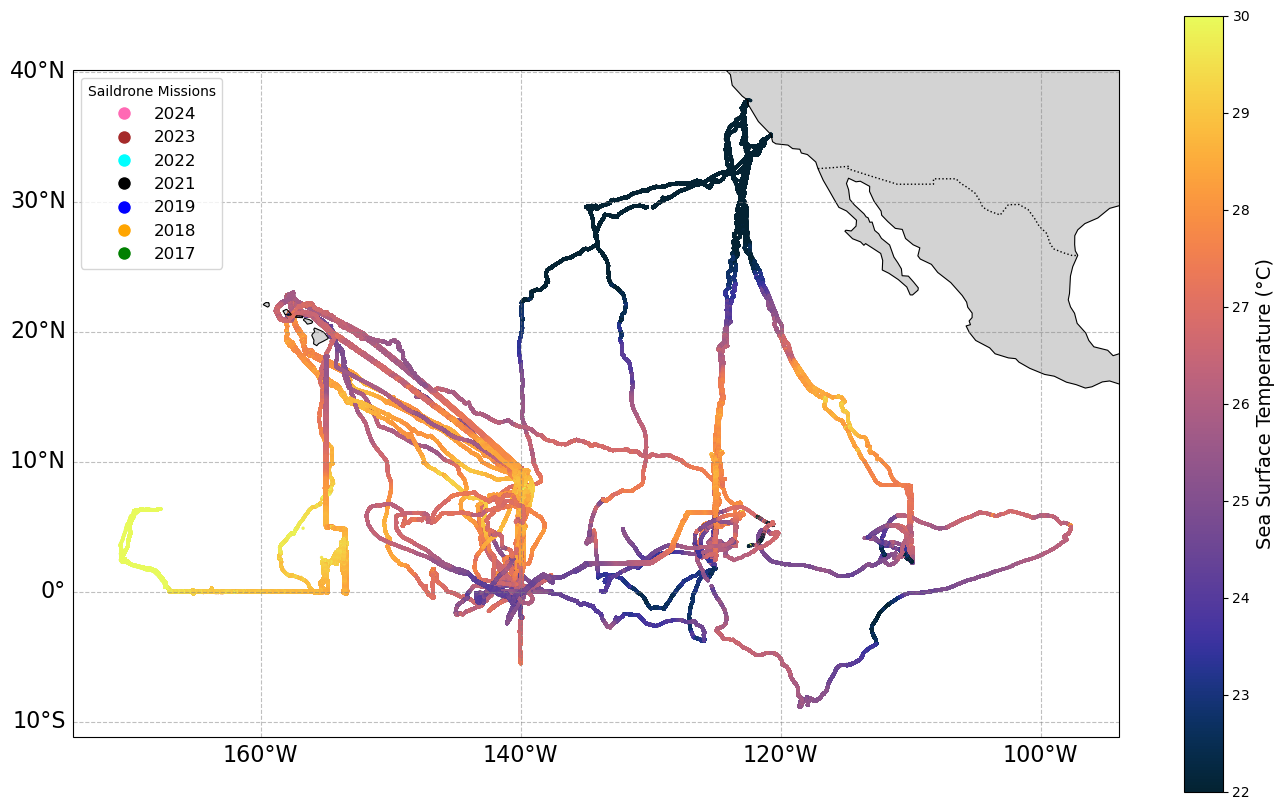

In [45]:
import os
import glob
import netCDF4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, to_rgba
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

# Path to saildrone track data
path = '/Volumes/external/TIW/data/saildrone/processed'

# Path to the fronts CSV file
file_path = '/Volumes/external/TIW/csv/Saildrone-fronts-QC-with-phase.csv'

# Load fronts data
df = pd.read_csv(file_path)
df['time'] = pd.to_datetime(df['time'])
valid_fronts = df[df['manual_QC'] == 0]  # Filter to only QC-approved fronts
valid_fronts = valid_fronts[valid_fronts['lat'] < 7]  # Restrict to a lat range

# Define years to include
years_to_include = [2017, 2018, 2019, 2021, 2022, 2023, 2024]
year_colors = {
    2017: 'green', 2018: 'orange', 2019: 'blue',
    2021: 'black', 2022: 'cyan', 2023: 'brown', 2024: 'hotpink'
}

# Store data files
drone_data = {}

for file in glob.glob(os.path.join(path, "*.nc")):
    base_name = os.path.basename(file)
    
    # Extract year and drone name
    year = base_name.split('_')[0]  # First part is the year
    drone_name = base_name.split('_')[1].split('.')[0]  # Extract drone ID
    
    if int(year) in years_to_include:
        drone_data.setdefault((int(year), drone_name), []).append(file)

# Initialize plot with Cartopy
plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

#ax.set_extent([-165, -105, -1, 20], crs=ccrs.PlateCarree())
ax.coastlines(resolution='110m', linewidth=0.8)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Gridlines
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}

# Store handles for legend
scatter_handles = []
scatter_labels = []

# Normalize temperature values for color mapping
temp_values = []

# Process each drone track file
for (year, drone_name), files in drone_data.items():
    base_color = year_colors[year]

    for file in files:
        try:
            with netCDF4.Dataset(file, 'r') as nc:
                # Read latitude, longitude, and temperature
                lat = nc.variables['lat'][:]
                lon = nc.variables['lon'][:]
                temp = nc.variables['temp'][:] if 'temp' in nc.variables else None

                # Handle missing values
                fill_value = getattr(nc.variables['lat'], '_FillValue', None)
                if fill_value is not None:
                    lat = np.where(lat == fill_value, np.nan, lat)
                    lon = np.where(lon == fill_value, np.nan, lon)
                
                # Remove NaNs
                valid_indices = np.isfinite(lat) & np.isfinite(lon)
                lat, lon = lat[valid_indices], lon[valid_indices]
                temp = temp[valid_indices] if temp is not None else None

                # Store temperature for normalization
                if temp is not None:
                    temp_values.extend(temp)

        except Exception as e:
            print(f"Error processing {file}: {e}")
# Normalize temperature for colormap
if temp_values:
    norm = Normalize(vmin=min(temp_values), vmax=max(temp_values))

    for (year, drone_name), files in drone_data.items():
        for file in files:
            try:
                with netCDF4.Dataset(file, 'r') as nc:
                    lat = nc.variables['lat'][:]
                    lon = nc.variables['lon'][:]
                    temp = nc.variables['temp'][:] if 'temp' in nc.variables else None

                    fill_value = getattr(nc.variables['lat'], '_FillValue', None)
                    if fill_value is not None:
                        lat = np.where(lat == fill_value, np.nan, lat)
                        lon = np.where(lon == fill_value, np.nan, lon)

                    valid_indices = np.isfinite(lat) & np.isfinite(lon)
                    lat, lon = lat[valid_indices], lon[valid_indices]
                    temp = temp[valid_indices] if temp is not None else None

                    # Plot data with color by temperature if available
                    if temp is not None:
                        scatter = ax.scatter(lon, lat, c=temp, cmap=cmocean.cm.thermal, vmin=22,vmax=30,
                                             s=2, transform=ccrs.PlateCarree())
                    else:
                        rgba_color = to_rgba(base_color, alpha=0.7)
                        scatter = ax.scatter(lon, lat, color=rgba_color,
                                             s=1, transform=ccrs.PlateCarree())

                    scatter_handles.append(scatter)
                    scatter_labels.append(f'{drone_name} ({year})')

            except Exception as e:
                print(f"Error processing {file}: {e}")

# Overlay front locations
for _, row in valid_fronts.iterrows():
    front_year = row['Mission']
    front_lat = row['lat']
    front_lon = row['lon']

#    if front_year in years_to_include:
#        ax.scatter(
#            front_lon, front_lat, color='red', marker='o', edgecolors='k', linewidth=1, s=200,
#            transform=ccrs.PlateCarree()
#        )

# Add colorbar for SST
if temp_values:
    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.8)
    cbar.set_label("Sea Surface Temperature (°C)", fontsize=14)

# Simplified legend with only years
unique_years = set(year for year, _ in drone_data.keys())
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=year_colors[yr], markersize=10)
                  for yr in sorted(unique_years, reverse=True)]
legend_labels = [str(yr) for yr in sorted(unique_years, reverse=True)]

plt.legend(legend_handles, legend_labels, loc='upper left', fontsize='large', title='Saildrone Missions')

# Show plot
plt.tight_layout()
plt.show()


In [11]:
file_path = '/Volumes/external/TIW/csv/Saildrone-fronts-QC-with-phase.csv'

df = pd.read_csv(file_path)
df=df[df['manual_QC']==0]

In [12]:
df

,Mission,SD,idx,time,lat,lon,manual_QC,temp_diff,front_type,phase
0,2017,1006,112861,11/19/17 9:00,7.995029,-125.015706,0,0.55,NaN,5.084179
1,2017,1006,113625,11/19/17 21:45,7.963386,-125.093798,0,0.69,NaN,5.162990
2,2017,1006,115825,11/21/17 10:24,7.398142,-125.055411,0,0.72,NaN,5.314903
3,2017,1006,138328,12/7/17 1:28,1.801646,-125.127603,0,1.29,NaN,3.854970
5,2017,1006,219720,2/1/18 13:59,4.393711,-142.410214,0,1.26,NaN,4.880768
6,2017,1005,116405,11/21/17 20:05,7.423547,-124.900570,0,0.65,NaN,5.609490
8,2017,1005,184849,1/8/18 8:49,4.919709,-134.649421,0,0.86,NaN,4.433847
9,2017,1005,185675,1/8/18 22:35,5.431602,-134.562752,0,0.71,NaN,4.748405
14,2018,1029,104812,12/15/18 18:52,3.841463,-142.842381,0,0.64,NaN,2.607628
18,2019,1069,69034,7/25/19 22:34,3.394784,-140.113293,0,0.61,NaN,NaN


In [14]:
len(df)

42